In [15]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
df = pd.read_csv('data\shopee_reviews.csv')
df.replace('', np.nan, inplace=True)
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna()

C:\Users\asus\AppData\Local\Temp\ipykernel_21780\3319899313.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data\shopee_reviews.csv')


In [25]:
custom_stopwords = set(stopwords.words('english')).union({
    'would', 'could', 'also', 'may', 'might', 'get', 'got', 'still',
    'even', 'much', 'many', 'though', 'yet', 'one', 'two', 'us', 'etc',
    'let', 'make', 'made', 'use', 'used', 'using', 'go', 'come', 'take',
    'keep', 'see', 'look', 'find', 'need', 'want', 'due', 'without',
    'among', 'within', 'upon', 'toward', 'unto', 'ever', 'however'
})

punctuation = set(string.punctuation)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    words = text.split()  # split by whitespace
    words = [w for w in words if w not in custom_stopwords]
    return ' '.join(words)

df['cleaned_text'] = df['text'].apply(clean_text)

print(df)

         label                                               text  cluster  \
0          5.0    looks ok like durable hv recommend others worth        1   
1          5.0  tried current powerful depending setting dont ...        1   
2          5.0  item received week looks smaller expected cant...        1   
3          5.0  thanks works describe complaints really expect...        1   
4          5.0  fast delivery considering overseas tried sure ...        1   
...        ...                                                ...      ...   
1502570    5.0                 tried fit nicely buy fast good buy        1   
1502571    5.0  fantastic product reasonable price good qualit...        1   
1502572    5.0  nice pair shoes gd price note cutting bit smal...        1   
1502573    1.0  leather rubbishmoulded plastic fakehow shoppee...        2   
1502574    3.0                size 41 smaller normal like size 40        2   

                                              cleaned_text  
0 

In [26]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['text'])

In [27]:
ratings_scaled = MinMaxScaler().fit_transform(df[['label']])
ratings_sparse = np.array(ratings_scaled)
X_combined = hstack([tfidf_matrix, ratings_sparse])

In [28]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_combined)
df['cluster'] = kmeans.labels_

In [35]:
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_[:, :len(terms)].argsort()[:, ::-1]

for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i} top terms: {', '.join(top_terms)}")

print(df)

print(df.groupby('cluster')['label'].mean())
print(df.groupby('cluster')['label'].value_counts(normalize=True))

Cluster 0 top terms: good, condition, received, item, fast, delivery, thank, well, quality, thanks
Cluster 1 top terms: delivery, good, fast, well, nice, quality, seller, received, item, buy
Cluster 2 top terms: size, item, quality, small, received, material, seller, good, delivery, thin
         label                                               text  cluster
0          5.0    looks ok like durable hv recommend others worth        1
1          5.0  tried current powerful depending setting dont ...        1
2          5.0  item received week looks smaller expected cant...        1
3          5.0  thanks works describe complaints really expect...        1
4          5.0  fast delivery considering overseas tried sure ...        1
...        ...                                                ...      ...
1502570    5.0                 tried fit nicely buy fast good buy        1
1502571    5.0  fantastic product reasonable price good qualit...        1
1502572    5.0  nice pair shoes gd p

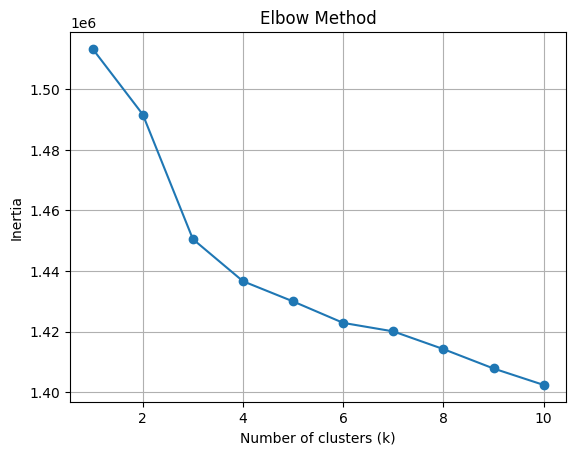

In [22]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_combined)
    inertia.append(kmeans.inertia_)

# Plot to visually find the elbow
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()


In [30]:
df = df.drop('cleaned_text', axis=1)
df.to_csv('clustering.csv', index=False)

In [33]:
df.describe(include='all')

,label,text,cluster
count,1.502573e+06,1502573,1.502573e+06
unique,NaN,1360829,NaN
top,NaN,,NaN
freq,NaN,2168,NaN
mean,4.753131e+00,NaN,9.004541e-01
std,7.442271e-01,NaN,4.667969e-01
min,1.000000e+00,NaN,0.000000e+00
25%,5.000000e+00,NaN,1.000000e+00
50%,5.000000e+00,NaN,1.000000e+00
75%,5.000000e+00,NaN,1.000000e+00


In [34]:
df['cluster'].value_counts()

cluster
1    1160274
0     245937
2      96362
Name: count, dtype: int64